# Installs, Imports, Drive Connection, WandB Connection

##### Installs

In [1]:
# !pip install transformers
!pip install git+https://github.com/huggingface/transformers.git
!pip install datasets==1.9.0
!pip install -U PyYAML
!pip install "ray[default]"
!pip install wandb
!pip install tensorboardX

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-dzpqzqt2
  Running command git clone -q https://github.com/huggingface/transformers.git /tmp/pip-req-build-dzpqzqt2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 636 kB 13.3 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 3.3 MB 28.7 MB/s 
     |████████████████████████████████| 895 kB 47.0 MB/s 
  Created wheel for transformers: filename=transformers-4.10.0.dev0-py3-none-any.whl size=2633486 sha256=0e48aadfd0988da46e2cf878d7bd550bdeabb46552815434fa09295326c65b81
  Stored in directory: /tmp/pip-ephem-wheel-cache-_fgg0pfr/wheels/90/a5/44/6bcd83827c8a60628c5ad602f429cd5076bcce5f2a90054947
Successfully built transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successf

##### Imports

In [2]:
import sys
import os
import numpy as np
# from transformers import pipeline
from datasets import concatenate_datasets, load_dataset
import torch
from pathlib import Path
import pickle
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments
from scipy.special import softmax
from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import math
from transformers import AutoModelForSequenceClassification

In [2]:
import os
import pickle
import numpy as np

import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import PopulationBasedTraining, ASHAScheduler
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from ray.tune.logger import DEFAULT_LOGGERS
from ray.tune.integration.wandb import WandbLoggerCallback, WandbLogger

from transformers import DistilBertConfig

from ray.tune.integration.wandb import WandbLoggerCallback
# from MultiTaskExtensions import DistilBERTForMultipleSequenceClassification

##### Drive Connection

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Get Configuration

In [4]:
import configparser
import sys
from pathlib import Path

config = configparser.ConfigParser()
config.read('/content/drive/MyDrive/Thesis/BookSuccessPredictor/config.ini')

drive_base_path = Path(config['Drive']['drive_base_path'])

sys.path.append(str(drive_base_path / 'BookSuccessPredictor' / '_utils'))

##### WandB Connection

In [5]:
# saves our models to artifacts in WandB
import wandb
%env WANDB_LOG_MODEL=true
%env WANDB_PROJECT=goodreads_success_predictor

env: WANDB_LOG_MODEL=true
env: WANDB_PROJECT=goodreads_success_predictor


In [6]:
wandb.login(key = config['WandB']['api_key'])

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Dataset Generator

### Load Text Data

#### goodreads_maharjan

In [ ]:
base_path = Path(config['Datasets']['nered_goodreads_maharjan_path'])
dataset = load_dataset(str(base_path / 'goodreadsnered.py'))

Dataset good_reads_practice_dataset downloaded and prepared to /root/.cache/huggingface/datasets/good_reads_practice_dataset/main_domain/1.1.0/fee2eb60ac7713af6f776b7c4dab63145144f749e5689ea3dc2299235f6f560e. Subsequent calls will reuse this data.


#### goodreads_guarro

In [ ]:
base_path = config['Datasets']['nered_goodreads_guarro_path']
dataset = load_dataset(base_path)

### Custom Tokenization Process

##### Get Tokenizer

In [ ]:
from transformers import AutoTokenizer

In [ ]:
if eval(config['Model']['use_ner']):
  tokenizer = AutoTokenizer.from_pretrained(config['Model']['name'], additional_special_tokens = ['[CHARACTER]'])
else:
  tokenizer = AutoTokenizer.from_pretrained(config['Model']['name'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


##### Do actual tokenizing and uploading

In [ ]:
from tokenization_algos import chunk_and_encode_examples_w_complete_sentences, chunk_and_encode_examples_w_overlap

In [ ]:
from functools import partial
encode_algo = partial(chunk_and_encode_examples_w_overlap, tokenizer=tokenizer)

In [ ]:
chunked_encoded_dataset = dataset.map(encode_algo, remove_columns=dataset.column_names['train'], batched = True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


When uploading the tokenized datasets to Drive, we may need to break them up into as many pieces as is necessary. Otherwise the serialization and uploading fails. In my case I had to split each subset (train, val, test) into 2 parts. If using tokenization with complete sentences, we can usually avoid this hack. Otherwise with overlap, the dataset will most likely be too large and this trick may be necessary.

In [ ]:
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 21539
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 5236
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 10816
    })
})

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

with open('train_dataset1.pkl', 'wb') as output_file:
  pickle.dump(chunked_encoded_dataset['train'][0:chunked_encoded_dataset['train'].num_rows//2], output_file)

with open('train_dataset2.pkl', 'wb') as output_file:
  pickle.dump(chunked_encoded_dataset['train'][chunked_encoded_dataset['train'].num_rows//2:chunked_encoded_dataset['train'].num_rows], output_file)

with open('val_dataset1.pkl', 'wb') as output_file:
  pickle.dump(chunked_encoded_dataset['validation'][0:chunked_encoded_dataset['validation'].num_rows//2], output_file)

with open('val_dataset2.pkl', 'wb') as output_file:
  pickle.dump(chunked_encoded_dataset['validation'][chunked_encoded_dataset['validation'].num_rows//2:chunked_encoded_dataset['validation'].num_rows], output_file)

with open('test_dataset1.pkl', 'wb') as output_file:
  pickle.dump(chunked_encoded_dataset['test'][0:chunked_encoded_dataset['test'].num_rows//2], output_file)

with open('test_dataset2.pkl', 'wb') as output_file:
  pickle.dump(chunked_encoded_dataset['test'][chunked_encoded_dataset['test'].num_rows//2:chunked_encoded_dataset['test'].num_rows], output_file)

folder_id = '1g6oTxM3CWsJmQMXSGOFpoavVmIWXVa02'
# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('train_dataset1.pkl')
file.Upload() 

file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('train_dataset2.pkl')
file.Upload() 

# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('val_dataset1.pkl')
file.Upload() 

file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('val_dataset2.pkl')
file.Upload() 

# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('test_dataset1.pkl')
file.Upload() 

file = drive.CreateFile({'parents':[{u'id': folder_id}]})
file.SetContentFile('test_dataset2.pkl')
file.Upload()

#### Loading

In [7]:
load_path = Path(config['Drive']['drive_base_path']) / 'BookSuccessPredictor' / 'datasets' / 'goodreads_maharjan_super' / 'already_tokenized'

In [8]:
if config['Datasets']['split'] == '80_20':
  load_path = load_path / '80_20'
else:
  load_path = load_path / '60_40'

In [9]:
if (config['Model']['name'] == 'albert-base-v2'):
  load_path = load_path / 'ALBERT_NER_512'

elif (config['Model']['name'] == 'bert-base-uncased'):
  if (config['Tokenizer']['max_len'] == '512'):
    load_path = load_path / 'BERT_UNCASED_NER_512'
  elif (config['Tokenizer']['max_len'] == '256'):
    load_path = load_path / 'BERT_UNCASED_NER_256'

elif (config['Model']['name'] == 'distilbert-base-uncased'):
  if (eval(config['Tokenizer']['overlap'])):
    load_path = load_path / 'DistilBERT_UNCASED_NER_512_w50overlap'
  else:
    load_path = load_path / 'DistilBERT_UNCASED_NER_512'

elif (config['Model']['name'] == 'roberta-base'):
  load_path = load_path / 'ROBERTA_NER_512'

elif (config['Model']['name'] == 'google/bigbird-roberta-base'):
  load_path = load_path / 'BIGBIRD_NER_4096'

In [10]:
load_path

PosixPath('/content/drive/MyDrive/Thesis/BookSuccessPredictor/datasets/goodreads_maharjan_super/already_tokenized/80_20/DistilBERT_UNCASED_NER_512_w50overlap')

In [11]:
from datasets import DatasetDict, Dataset, concatenate_datasets
train_paths = [f for f in os.listdir(load_path) if f.startswith('train')]
val_paths = [f for f in os.listdir(load_path) if f.startswith('val')]
test_paths = [f for f in os.listdir(load_path) if f.startswith('test')]

train_datasets = []
val_datasets = []
test_datasets = []

for trainp in train_paths:
  with open(load_path / trainp, "rb") as input_file:
    train_datasets.append(Dataset.from_dict(pickle.load(input_file)))

for valp in val_paths:
  with open(load_path / valp, "rb") as input_file:
    val_datasets.append(Dataset.from_dict(pickle.load(input_file)))

for testp in test_paths:
  with open(load_path / testp, "rb") as input_file:
    test_datasets.append(Dataset.from_dict(pickle.load(input_file)))

train_dataset = concatenate_datasets(train_datasets)
del train_datasets

val_dataset = concatenate_datasets(val_datasets)
del val_datasets

test_dataset = concatenate_datasets(test_datasets)
del test_datasets

chunked_encoded_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})

In [12]:
if (config['Model']['multi_task']):
  # When batched = True, we take in multiple examples
  def group_success_and_genre(examples):
    examples['labels'] = np.vstack((examples['success_label'], examples['genre'])).T
    return examples

  chunked_encoded_dataset = chunked_encoded_dataset.map(group_success_and_genre, batched = True, remove_columns=['genre', 'success_label'])
else:
  chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label', 'labels')

#Dataset Exploration

In [ ]:
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 15752
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 11023
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'genre', 'input_ids', 'success_label', 'token_type_ids'],
        num_rows: 10816
    })
})

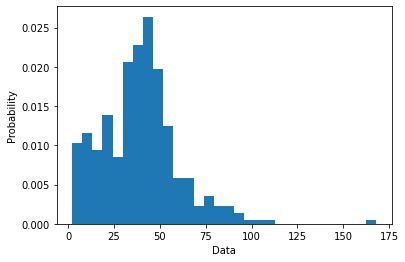

In [ ]:
import matplotlib.pyplot as plt
import itertools

num_segments_per_book = [len(list(g[1])) for g in itertools.groupby(chunked_encoded_dataset['train']['book_title'])]

plt.hist(num_segments_per_book, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [ ]:
# [(g[0], len(list(g[1]))) for g in itertools.groupby(chunked_encoded_dataset['train']['book_title'])]
start_of_segmented_book = {}
last_idx = 0
for g in itertools.groupby(chunked_encoded_dataset['train']['book_title']):
  start_of_segmented_book[g[0]] = last_idx
  last_idx = len(list(g[1])) + last_idx

In [ ]:
start_of_segmented_book

{'10002_the+house+on+the+borderland.txt': 10969,
 "1006_divine+comedy+cary's+translation+purgatory.txt": 8310,
 '10083_the+house+of+the+whispering+pines.txt': 12906,
 '1020_sword+blades+and+poppy+seed.txt': 6111,
 '10671_the+botanic+garden.txt': 9771,
 '1069_four+short+stories+by+emile+zola.txt': 391,
 '1074_the+sea+wolf.txt': 13453,
 '1093_the+beast+in+the+jungle.txt': 5285,
 '1096_the+faith+of+men.txt': 2218,
 "1097_mrs+warren's+profession.txt": 10188,
 '1144_in+the+cage.txt': 1945,
 '1151_the+nibelungenlied.txt': 9470,
 '11656_the+great+shadow+and+other+napoleonic+tales.txt': 10655,
 '12116_struwwelpeter+merry+stories+and+funny+pictures.txt': 8761,
 '1218_the+adventures+of+jimmie+dale.txt': 9606,
 '12241_poems+by+emily+dickinson+third+series.txt': 1754,
 '12242_poems+by+emily+dickinson+three+series.txt': 10152,
 '1238_the+city+of+dreadful+night.txt': 8978,
 '1240_the+playboy+of+the+western+world.txt': 12638,
 '12509_the+moon+rock.txt': 7687,
 '1261_betty+zane.txt': 2260,
 '1279_poem

In [ ]:
# When batched = True, we take in multiple examples
def filter_segments(example, idx):
  if (idx - start_of_segmented_book[example['book_title']] < 40):
    return True
  else:
    return False

test = chunked_encoded_dataset['train'].filter(filter_segments, with_indices = True)

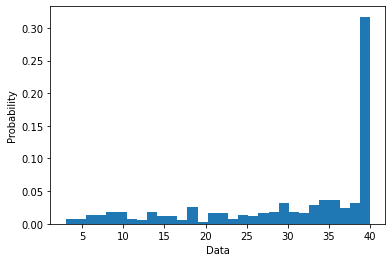

In [ ]:
num_segments_per_book = [len(list(g[1])) for g in itertools.groupby(test['book_title'])]

plt.hist(num_segments_per_book, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [ ]:
chunked_encoded_dataset['train'] = chunked_encoded_dataset['train'].filter(filter_segments, with_indices = True)

# GoodReads Success Prediction

## Transformer --> Classification

In [ ]:
from MultiTaskExtensions import DistilBERTForMultipleSequenceClassification
from transformers import DistilBertConfig
pretrained_model_name_or_path = config['Model']['name']
if (config['WandB']['use_WandB_pretrained']):
  run = wandb.init()
  artifact = run.use_artifact('lucaguarro/goodreads_success_predictor/model-1fajaalf:v0', type='model')
  pretrained_model_name_or_path = artifact.download()

if (config['Model']['multi_task']):
  metric_for_best_model = 'eval_s_f1'
  if (config['Model']['name'] == 'distilbert-base-uncased'):
    from MultiTaskExtensions import DistilBERTForMultipleSequenceClassification
    db_config = DistilBertConfig.from_pretrained(pretrained_model_name_or_path)
    db_config.update({'_name_or_path': pretrained_model_name_or_path, 'alpha': 0.5})
    print(db_config)
    model = DistilBERTForMultipleSequenceClassification.from_pretrained(pretrained_model_name_or_path = db_config._name_or_path, config = db_config)
  else:
    from MultiTaskExtensions import BertForMultipleSequenceClassification
    model = BertForMultipleSequenceClassification.from_pretrained(pretrained_model_name_or_path)

else:
  metric_for_best_model = 'eval_f1'
  model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path)
  model.resize_token_embeddings(len(tokenizer))

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact model-1fajaalf:v0, 255.57MB. 3 files... Done. 0:0:0


DistilBertConfig {
  "_name_or_path": "./artifacts/model-1fajaalf:v0",
  "activation": "gelu",
  "alpha": 0.5,
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.10.0.dev0",
  "vocab_size": 30523
}

2 8


Some weights of the model checkpoint at ./artifacts/model-1fajaalf:v0 were not used when initializing DistilBERTForMultipleSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBERTForMultipleSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBERTForMultipleSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBERTForMultipleSequenceClassification were not initialized from the model checkpoint at ./artifacts/model-1fajaalf:v0 and are newly initialized: ['classifier

In [ ]:
%env WANDB_PROJECT=goodreads_success_predictor_80_20

training_args = TrainingArguments(
    'goodreads_success_predictor_80_20',
    # output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    learning_rate=0.00005,
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=19,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    # logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "steps",
    eval_steps = 5, # prob better if set to 601 that way it evenly divides into the epochs
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_s_f1',
    greater_is_better = True,
    report_to = "wandb",
    save_total_limit = 5
    # learning rate, play around with weight_decay
    # select best model (and not the last one); use validation loss to pick the best model
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=chunked_encoded_dataset['train'],         # training dataset             # evaluation dataset
    eval_dataset=chunked_encoded_dataset['validation'], 
    compute_metrics = compute_metrics
)

trainer.train()

env: WANDB_PROJECT=goodreads_success_predictor_80_20


The following columns in the training set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: token_type_ids, book_title.
***** Running training *****
  Num examples = 21539
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1347
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,S Accuracy,S F1,S Precision,S Recall,G Accuracy,G F1,G Precision,G Recall
5,No log,1.375320,0.575057,0.588714,0.615568,0.575057,0.575057,0.039240,0.037289,0.133881
10,1.365100,1.328491,0.689840,0.563223,0.475879,0.689840,0.689840,0.042373,0.027536,0.120130
15,1.365100,1.332960,0.689840,0.563223,0.475879,0.689840,0.689840,0.050028,0.031881,0.139228
20,1.271800,1.298958,0.689840,0.563223,0.475879,0.689840,0.689840,0.054179,0.039209,0.152979
25,1.271800,1.254526,0.689840,0.563223,0.475879,0.689840,0.689840,0.074017,0.049225,0.192513
30,1.201200,1.190378,0.689840,0.563223,0.475879,0.689840,0.689840,0.076626,0.049801,0.181054
35,1.201200,1.149097,0.689840,0.563223,0.475879,0.689840,0.689840,0.094653,0.078372,0.205309
40,1.119900,1.137905,0.689840,0.563223,0.475879,0.689840,0.689840,0.071185,0.061510,0.184110
45,1.119900,1.166667,0.689840,0.563223,0.475879,0.689840,0.689840,0.087293,0.056279,0.209702
50,1.117000,1.131180,0.689840,0.563223,0.475879,0.689840,0.689840,0.089642,0.058250,0.210275


The following columns in the evaluation set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: token_type_ids, book_title.
***** Running Evaluation *****
  Num examples = 5236
  Batch size = 32
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to goodreads_success_predictor_80_20/checkpoint-5
Configuration saved in goodreads_success_predictor_80_20/checkpoint-5/config.json
Model weights saved in goodreads_success_predictor_80_20/checkpoint-5/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: token_type_ids, book_tit

## Scorer

In [13]:
from MultiTaskExtensions import DistilBERTForMultipleSequenceClassification

In [14]:
run = wandb.init()
artifact = run.use_artifact('lucaguarro/DistilbertMultitaskHPSearch/model-5mc084iz:v0', type='model')
artifact_dir = artifact.download()

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact model-5mc084iz:v0, 255.48MB. 3 files... Done. 0:0:0


In [15]:
model = DistilBERTForMultipleSequenceClassification.from_pretrained(artifact_dir)
trainer = Trainer(
    model=model
)

2 8


In [16]:
from scores import ModelScorer

In [17]:
m_scorer = ModelScorer(trainer, chunked_encoded_dataset, for_multitask=True)

The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 5236
  Batch size = 8


Getting predictions on validation set


The following columns in the test set  don't have a corresponding argument in `DistilBERTForMultipleSequenceClassification.forward` and have been ignored: token_type_ids, book_title.
***** Running Prediction *****
  Num examples = 10816
  Batch size = 8


Getting predictions on test set


*******************************************************************
********************** SEGMENTED F1 SCORE *************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The max weighted f1 score is 0.7393925322435507 with a threshold of 0.5600000000000002 



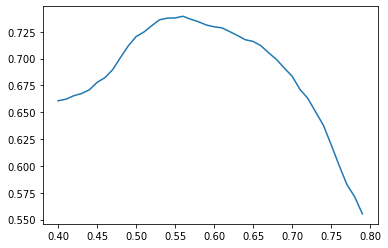

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6709725402981204 using the validated threshold of 0.5600000000000002 



In [18]:
m_scorer.get_segmented_f1_scores()

*******************************************************************
************************ BOOK F1 SCORE ****************************
*******************************************************************
*****SCORE ON VALIDATION SET*****
The max weighted f1 score is 0.7775894117242093 with a threshold of 0.5600000000000002 



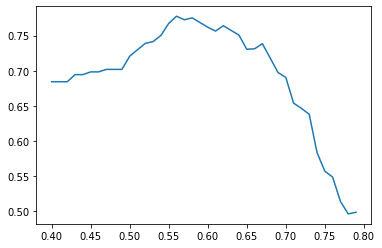

*****SCORE ON TEST SET*****
The weighted f1 score is 0.6506239260630933 using a threshold of 0.5 

The weighted f1 score is 0.6934311579963056 using the validated threshold of 0.5600000000000002 



In [19]:
m_scorer.get_book_f1_scores()

# Hyperparameter Tuning

multitask hyperparameter tuning

In [13]:
# saves our models to artifacts in WandB
%env WANDB_LOG_MODEL=true
wandb.login()
%env WANDB_PROJECT=DistilbertMultitaskHPSearch

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)


env: WANDB_LOG_MODEL=true
env: WANDB_PROJECT=DistilbertMultitaskHPSearch


In [14]:
chunked_encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'book_title', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 21539
    })
    validation: Dataset({
        features: ['attention_mask', 'book_title', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 5236
    })
    test: Dataset({
        features: ['attention_mask', 'book_title', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 10816
    })
})

In [15]:
def compute_metrics_single(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def compute_metrics_multi(pred):
    preds = pred.predictions
    label_ids = pred.label_ids

    success_labels = label_ids[:, 0]
    genre_labels = label_ids[:, 1]

    success_preds = preds[:, 0:2].argmax(1)
    genre_preds = preds[:, 2:6].argmax(1)

    s_precision, s_recall, s_f1, _ = precision_recall_fscore_support(success_labels, success_preds, average='weighted')
    s_acc = accuracy_score(success_labels, success_preds)

    g_precision, g_recall, g_f1, _ = precision_recall_fscore_support(genre_labels, genre_preds, average='weighted')
    g_acc = accuracy_score(success_labels, success_preds)

    return {
        's_accuracy': s_acc,
        's_f1': s_f1,
        's_precision': s_precision,
        's_recall': s_recall,
        'g_accuracy': g_acc,
        'g_f1': g_f1,
        'g_precision': g_precision,
        'g_recall': g_recall
    }

if config['Model']['multi_task']:
  # from scores import compute_metrics_multi
  compute_metrics = compute_metrics_multi
else:
  # from scores import compute_metrics_single
  compute_metrics = compute_metrics_single

def my_objective(metrics):
    # Your elaborate computation here
    if config['Model']['multi_task']:
      return metrics['eval_s_f1']
    else:
      return metrics['eval_f1']

In [16]:
db_config_base = DistilBertConfig.from_pretrained('/content/drive/MyDrive/Thesis/BookSuccessPredictor/saved_models/DistilBertPretrained')
db_config_base.update({'_name_or_path': '/content/drive/MyDrive/Thesis/BookSuccessPredictor/saved_models/DistilBertPretrained', 'alpha': 0.2, 'dropout': 0.8})

In [17]:
db_config_base

DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/Thesis/BookSuccessPredictor/saved_models/DistilBertPretrained",
  "activation": "gelu",
  "alpha": 0.2,
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.8,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.10.0.dev0",
  "vocab_size": 30523
}

In [ ]:
test = DistilBERTForMultipleSequenceClassification.from_pretrained(pretrained_model_name_or_path = db_config_base._name_or_path, config = db_config_base)

NameError: ignored

In [18]:
# tune_config_pop_based = {
#     "per_device_train_batch_size": 16,
#     "per_device_eval_batch_size": 32,
#     "num_train_epochs": 1,
#     "max_steps": 1 if smoke_test else -1,  # Used for smoke test.
#     "wandb": {
#         "project": "DistilbertMultitaskHPSearch",
#         "group": "Search1",
#         "api_key": "XXXXXXXX",
#         "log_config": True
#     }
# }

# scheduler = PopulationBasedTraining(
#     time_attr="training_iteration",
#     metric="eval_s_f1",
#     mode="max",
#     perturbation_interval=60,
#     hyperparam_mutations={
#         "weight_decay": tune.uniform(0.0, 0.3),
#         "learning_rate": tune.uniform(1e-5, 5e-5),
#         "per_device_train_batch_size": [16],
#     })

In [19]:
from transformers.modeling_outputs import SequenceClassifierOutput
from torch import nn
import torch
from torch.nn import CrossEntropyLoss, MSELoss

from transformers import DistilBertPreTrainedModel, DistilBertModel
class DistilBERTForMultipleSequenceClassification(DistilBertPreTrainedModel):
    def __init__(self, config, num_labels1 = 2, num_labels2 = 8):
        super().__init__(config)
        self.num_labels1 = num_labels1
        self.num_labels2 = num_labels2
        print(self.num_labels1, self.num_labels2)
        self.alpha = config.alpha
        self.config = config

        self.distilbert = DistilBertModel(config)
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        self.classifier1 = nn.Linear(config.dim, self.num_labels1)
        self.classifier2 = nn.Linear(config.dim, self.num_labels2)
        self.dropout = nn.Dropout(config.dropout)

        self.init_weights()


    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        distilbert_output = self.distilbert(
              input_ids=input_ids,
              attention_mask=attention_mask,
              head_mask=head_mask,
              inputs_embeds=inputs_embeds,
              output_attentions=output_attentions,
              output_hidden_states=output_hidden_states,
              return_dict=return_dict,
          )
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        logits1 = self.classifier1(pooled_output)
        logits2 = self.classifier2(pooled_output)
        logits = torch.cat([logits1, logits2], 1)

        loss = None
        if labels is not None:
            #if self.config.problem_type is None:
            #self.config.problem_type = "single_label_classification"
            
            if self.num_labels1 > 1:
                loss_fct1 = CrossEntropyLoss()
                loss1 = loss_fct1(logits1.view(-1, self.num_labels1), labels[:, 0].view(-1))
            else:
                loss_fct1 = MSELoss()
                loss1 = loss_fct1(logits1.view(-1), labels[:, 0].view(-1))

            if self.num_labels2 > 1:
                loss_fct2 = CrossEntropyLoss()
                loss2 = loss_fct2(logits2.view(-1, self.num_labels2), labels[:, 1].view(-1))
            else:
                loss_fct2 = MSELoss()
                loss2 = loss_fct2(logits2.view(-1), labels[:, 1].view(-1))
            loss = self.alpha*loss1 + (1-self.alpha)*loss2 

        if not return_dict:
            output = (logits,) + outputs[2:] #not sure if this works
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=distilbert_output.hidden_states, #hidden_states,
            attentions=distilbert_output.attentions, #attentions,
        )

In [20]:
def tune_transformer(num_samples=8, gpus_per_trial=0, smoke_test=False):
    data_dir_name = "./data" if not smoke_test else "./test_data"
    data_dir = os.path.abspath(os.path.join(os.getcwd(), data_dir_name))
    if not os.path.exists(data_dir):
        os.mkdir(data_dir, 0o755)

    def get_model(params):
        db_config = db_config_base
        print("printing params", params)
        if params is not None:
          db_config.update({'_name_or_path': '/content/drive/MyDrive/Thesis/BookSuccessPredictor/saved_models/DistilBertPretrained', 'alpha': params['alpha'], 'attention_dropout': params['attention_dropout'], 'dropout': params['dropout']})
        return DistilBERTForMultipleSequenceClassification.from_pretrained(pretrained_model_name_or_path = db_config_base._name_or_path, config = db_config_base)

    train_dataset = chunked_encoded_dataset['train']
    eval_dataset = chunked_encoded_dataset['validation']

    training_args = TrainingArguments(
        output_dir="DistilBertMultitask_HPsearch",
        learning_rate=1e-5,  # config
        do_train=True,
        do_eval=True,
        no_cuda=gpus_per_trial <= 0,
        evaluation_strategy="steps",
        save_total_limit = 5,
        logging_strategy="steps",
        logging_steps=5,
        eval_steps=5,
        load_best_model_at_end=True,
        # metric_for_best_model='eval_s_f1',
        # greater_is_better=True,
        num_train_epochs=0.9,  # config
        per_device_train_batch_size=16,  # config
        per_device_eval_batch_size=16,  # config
        warmup_steps=0,
        weight_decay=0.1,  # config
        logging_dir="./logs",
        skip_memory_metrics=True)

    tune_config_ASHA = {
        "attention_dropout": tune.uniform(0.15,0.4),
        "dropout": tune.uniform(0.15, 0.4),
        "alpha": tune.uniform(0.3,0.7),
        "learning_rate": tune.loguniform(1e-5, 1e-4),
        "gradient_accumulation_steps": tune.choice([2]),
        "per_device_train_batch_size": tune.choice([16]),
        "num_train_epochs": tune.choice([0.9]),
        "wandb": {
            "project": "DistilbertMultitaskHPSearch",
            "group": "Search1",
            "api_key": config['WandB']['api_key'],
            "log_config": True
        }
    }

    trainer = Trainer(
        model_init=get_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics)
    

    # scheduler = ASHAScheduler(
    #     metric="eval_s_f1",
    #     mode="max",
    #     max_t=1000,
    #     grace_period=30,
    #     reduction_factor=1.5)

    # scheduler = ASHAScheduler(
    #     metric="eval_s_f1",
    #     mode="max",
    #     max_t=1,
    #     grace_period=1,
    #     reduction_factor=2)

    reporter = CLIReporter(
        parameter_columns={
            "weight_decay": "w_decay",
            "learning_rate": "lr",
            "dropout": "dropout",
            "alpha": "alpha",
            "per_device_train_batch_size": "train_bs/gpu",
            "num_train_epochs": "num_epochs"
        },
        metric_columns=[
            "eval_s_accuracy", "eval_loss", "eval_s_f1", "steps", "training_iteration"
        ])

    trainer.hyperparameter_search(
        hp_space=lambda _: tune_config_ASHA,
        backend="ray",
        # compute_objective=my_objective,
        direction="maximize",
        n_trials=num_samples,
        resources_per_trial={
            "cpu": 2,
            "gpu": gpus_per_trial
        },
        # scheduler=scheduler,
        keep_checkpoints_num=1,
        checkpoint_score_attr="training_iteration",
        stop={"training_iteration": 1} if smoke_test else None,
        progress_reporter=reporter,
        local_dir="~/ray_results/",
        name="tune_transformer",
        loggers=DEFAULT_LOGGERS + (WandbLogger,))
        # time_budget_s=60*60*10) # 10 hours

In [ ]:
tune_transformer(num_samples=3, gpus_per_trial=1, smoke_test=False)
# tune_transformer(num_samples=1, gpus_per_trial=0, smoke_test=True)

standard hyperparameter tuning

In [ ]:
# saves our models to artifacts in WandB
import wandb
%env WANDB_LOG_MODEL=true
wandb.login()

In [ ]:
import os
import pickle

import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import PopulationBasedTraining
from transformers import AutoConfig, \
    AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from ray.tune.logger import DEFAULT_LOGGERS
from ray.tune.integration.wandb import WandbLoggerCallback, WandbLogger
from transformers import ElectraTokenizerFast, ElectraForSequenceClassification, BertTokenizer, BertForSequenceClassification

In [ ]:
model_name = 'bert-base-uncased'

In [ ]:
project_name = "BERT-base-uncased-HP-Tuning"
%env WANDB_PROJECT=BERT-base-uncased-HP-Tuning

env: WANDB_PROJECT=BERT-base-uncased-HP-Tuning


In [ ]:
from datasets import DatasetDict

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BERT_UNCASED_NER_512/train_dataset.pkl", "rb") as input_file:
  train_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BERT_UNCASED_NER_512/val_dataset.pkl", "rb") as input_file:
  val_dataset = pickle.load(input_file)

with open(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/PreTokenized/BERT_UNCASED_NER_512/test_dataset.pkl", "rb") as input_file:
  test_dataset = pickle.load(input_file)

chunked_encoded_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})
chunked_encoded_dataset = chunked_encoded_dataset.rename_column('success_label', 'labels')

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def tune_transformer(num_samples=8,
                     gpus_per_trial=0,
                     smoke_test=False,
                     ray_address=None):
    ray.init(ray_address, log_to_driver=True)
    data_dir_name = "./data" if not smoke_test else "./test_data"
    data_dir = os.path.abspath(os.path.join(os.getcwd(), data_dir_name))
    if not os.path.exists(data_dir):
        os.mkdir(data_dir, 0o755)

    # Change these as needed.
    # model_name = 'google/electra-small-discriminator' if not smoke_test \
    #     else 'google/electra-small-discriminator'
    task_name = "grs"

    task_data_dir = os.path.join(data_dir, task_name.upper())

    num_labels = 2

    # config = AutoConfig.from_pretrained(
    #     model_name, num_labels=num_labels, finetuning_task=task_name)

    # Download and cache tokenizer, model, and features
    print("Downloading and caching Tokenizer")
    # tokenizer = ElectraTokenizerFast.from_pretrained('google/electra-small-discriminator', additional_special_tokens = ['[CHARACTER]'])
    tokenizer = BertTokenizer.from_pretrained(model_name, additional_special_tokens = ['[CHARACTER]'])
    
    # Triggers tokenizer download to cache
    # print("Downloading and caching pre-trained model")
    # AutoModelForSequenceClassification.from_pretrained(
    #     model_name,
    #     config=config,
    # )

    def get_model():
        # model = ElectraForSequenceClassification.from_pretrained('/content/drive/MyDrive/Thesis/Models/ELECTRA_small_pretrained', num_labels=2)
        model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
        model.resize_token_embeddings(len(tokenizer))
        return model

    train_dataset = chunked_encoded_dataset['train']
    eval_dataset = chunked_encoded_dataset['validation']

    training_args = TrainingArguments(
        project_name,
        # output_dir=".",
        learning_rate=1e-5,  # config
        do_train=True,
        do_eval=True,
        no_cuda=gpus_per_trial <= 0,
        evaluation_strategy="epoch",
        load_best_model_at_end=True,
        num_train_epochs=2,  # config
        max_steps=-1,
        per_device_train_batch_size=16,  # config
        per_device_eval_batch_size=16,  # config
        warmup_steps=0,
        weight_decay=0.1,  # config
        # logging_dir="./logs",
    )

    training_args._n_gpu = gpus_per_trial

    trainer = Trainer(
        model_init=get_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics)

    tune_config = {
        # "per_device_train_batch_size": 16,
        "per_device_eval_batch_size": 32,
        "num_train_epochs": tune.choice([2, 3, 4, 5]),
        "max_steps": 1 if smoke_test else -1,  # Used for smoke test.
        "wandb": {
            "project": project_name,
            "api_key": config['WandB']['api_key'],
            "log_config": True
        }
    }

    scheduler = PopulationBasedTraining(
        time_attr="training_iteration",
        metric="eval_f1",
        mode="max",
        perturbation_interval=1,
        hyperparam_mutations={
            "weight_decay": tune.uniform(0.0, 0.3),
            "warmup_steps": tune.choice([0, 50, 100, 500, 1000]),
            "learning_rate": tune.uniform(1e-5, 4e-5),
            "per_device_train_batch_size": [8, 16],
        })

    reporter = CLIReporter(
        parameter_columns={
            "weight_decay": "w_decay",
            "learning_rate": "lr",
            "per_device_train_batch_size": "train_bs/gpu",
            "num_train_epochs": "num_epochs"
        })

    trainer.hyperparameter_search(
        hp_space=lambda _: tune_config,
        backend="ray",
        n_trials=num_samples,
        resources_per_trial={
            "cpu": 1,
            "gpu": gpus_per_trial
        },
        scheduler=scheduler,
        keep_checkpoints_num=1,
        checkpoint_score_attr="training_iteration",
        stop={"training_iteration": 1} if smoke_test else None,
        progress_reporter=reporter,
        local_dir="~/ray_results/",
        name="tune_transformer_pbt",
        # log_to_file=True,
        loggers=DEFAULT_LOGGERS + (WandbLogger, ),
        time_budget_s=60*15
    )

In [ ]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument(
    "--smoke-test", action="store_true", help="Finish quickly for testing")
parser.add_argument(
    "--ray-address",
    type=str,
    default=None,
    help="Address to use for Ray. "
    "Use \"auto\" for cluster. "
    "Defaults to None for local.")
args, _ = parser.parse_known_args()

if args.smoke_test:
    tune_transformer(
        num_samples=1,
        gpus_per_trial=0,
        smoke_test=True,
        ray_address=args.ray_address)
else:
    # You can change the number of GPUs here:
    tune_transformer(
        num_samples=15, gpus_per_trial=1, ray_address=args.ray_address)

2021-06-04 00:26:06,735	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

== Status ==
Memory usage on this node: 3.8/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.99 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+------------------------+----------+-------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc   |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-------+------------+-------------+----------------+--------------|
| _objective_8723f_00000 | RUNNING  |       | 0.238963   | 3.33907e-05 |              8 |            4 |
| _objective_8723f_00001 | PENDING  |       | 0.0468056  | 1.29992e-05 |              8 |            2 |
| _objective_8723f_00002 | PENDING  |       | 0.259853   | 1.4286e-05  |             16 |            4 |
| _objective_8723f_00003 | PENDING  |       | 0

(pid=486) 2021-06-04 00:26:40.478108: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


== Status ==
Memory usage on this node: 5.0/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.99 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+------------------------+----------+-------+------------+-------------+----------------+--------------+
| Trial name             | status   | loc   |    w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+-------+------------+-------------+----------------+--------------|
| _objective_8723f_00000 | RUNNING  |       | 0.238963   | 3.33907e-05 |              8 |            4 |
| _objective_8723f_00001 | PENDING  |       | 0.0468056  | 1.29992e-05 |              8 |            2 |
| _objective_8723f_00002 | PENDING  |       | 0.259853   | 1.4286e-05  |             16 |            4 |
| _objective_8723f_00003 | PENDING  |       | 0

(pid=486) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
(pid=486) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=486) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=486) Some weights of BertForSequenceClassification were not 

(pid=486) 
(pid=486) signal only works in main thread
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)
wandb: WARNING Tried to auto resume run with id 8723f_00000 but id 8723f_00001 is set.
(pid=486) tcmalloc: large alloc 1095016448 bytes == 0x560d3c06e000 @  0x7f3804ea9615 0x560bfebd0cdc 0x560bfecb052a 0x560bfece8fc3 0x560bfebd4bde 0x560bfebd4b09 0x7f3805129692 0x7f380512b17b 0x7f380513174a 0x7f3805131a96 0x7f3805131a96 0x7f3805131ffe 0x7f3805132167 0x560bfebd3afd 0x560bfecc4fed 0x560bfec47d16 0x560bfebd530a 0x560bfec4360e 0x560bfec424ae 0x560bfebd53ea 0x560bfec477f0 0x560bfebd530a 0x560bfec477f0 0x560bfebd530a 0x560bfec477f0 0x560bfeb14d14 0x560bfec44bb5 0x560bfec427ad 0x560bfeb14eb1 0x7f3801c6118f 0x7f3801ca932a
(pid=486) tcmalloc: large alloc 1368776704 bytes == 0x560d7d4b8000 @  0x7f3804ea9615 0x560bfebd0cdc 0x560bfecb052a 0x560bfece8fc3 0x560bfebd4bde 0x560bfebd4b09 0x7f380512b19c 0x7f380513174a 0x7f3805131a96 0x7f3805131a96 0x7f3805131ffe 0x7f3805132167 0x560bfebd3afd 0x560bfecc4fed 0x560bfec

(pid=486) tcmalloc: large alloc 1710972928 bytes == 0x560d07d00000 @  0x7f3804ea9615 0x560bfebd0cdc 0x560bfecb052a 0x560bfece8fc3 0x560bfebd4bde 0x560bfebd4b09 0x7f3805129692 0x7f3805132173 0x560bfebd3afd 0x560bfecc4fed 0x560bfec47d16 0x560bfebd530a 0x560bfec4360e 0x560bfec424ae 0x560bfebd53ea 0x560bfec477f0 0x560bfebd530a 0x560bfec477f0 0x560bfebd530a 0x560bfec477f0 0x560bfeb14d14 0x560bfec44bb5 0x560bfec427ad 0x560bfeb14eb1 0x7f3801c6118f 0x7f3801ca932a 0x7f3801c6118f 0x7f3801d0a227 0x7f3801c695fa 0x7f3801dd4697 0x7f3801d4f222
(pid=486) 2021-06-04 00:38:25,468	INFO trainable.py:76 -- Checkpoint size is 1314035595 bytes
(pid=486) Error in atexit._run_exitfuncs:
(pid=486) Traceback (most recent call last):
(pid=486)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=486)     self._writeout_input_cache(conn)
(pid=486)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=486

(pid=486) <IPython.core.display.HTML object>


(pid=483) 2021-06-04 00:38:27.675400: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>
(pid=486) <IPython.core.display.HTML object>


(pid=483) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
(pid=483) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=483) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=483) Some weights of BertForSequenceClassification were not 

(pid=483) 
(pid=483) signal only works in main thread
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(

(pid=483) tcmalloc: large alloc 1095016448 bytes == 0x564374cac000 @  0x7f3b8e8a9615 0x5642377d5cdc 0x5642378b552a 0x5642378edfc3 0x5642377d9bde 0x5642377d9b09 0x7f3b8eb29692 0x7f3b8eb2b17b 0x7f3b8eb3174a 0x7f3b8eb31a96 0x7f3b8eb31a96 0x7f3b8eb31ffe 0x7f3b8eb32167 0x5642377d8afd 0x5642378c9fed 0x56423784cd16 0x5642377da30a 0x56423784860e 0x5642378474ae 0x5642377da3ea 0x56423784c7f0 0x5642377da30a 0x56423784c7f0 0x5642377da30a 0x56423784c7f0 0x564237719d14 0x564237849bb5 0x5642378477ad 0x564237719eb1 0x7f3b8b66118f 0x7f3b8b6a932a
(pid=483) tcmalloc: large alloc 1368776704 bytes == 0x5643b60f6000 @  0x7f3b8e8a9615 0x5642377d5cdc 0x5642378b552a 0x5642378edfc3 0x5642377d9bde 0x5642377d9b09 0x7f3b8eb2b19c 0x7f3b8eb3174a 0x7f3b8eb31a96 0x7f3b8eb31a96 0x7f3b8eb31ffe 0x7f3b8eb32167 0x5642377d8afd 0x5642378c9fed 0x56423784cd16 0x5642377da30a 0x56423784860e 0x5642378474ae 0x5642377da3ea 0x56423784c7f0 0x5642377da30a 0x56423784c7f0 0x5642377da30a 0x56423784c7f0 0x564237719d14 0x564237849bb5 0x564

(pid=483) <IPython.core.display.HTML object>


(pid=484) 2021-06-04 00:50:23.049065: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>
(pid=483) <IPython.core.display.HTML object>


(pid=484) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
(pid=484) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=484) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=484) Some weights of BertForSequenceClassification were not 

(pid=484) 
(pid=484) signal only works in main thread
(pid=484) <IPython.core.display.HTML object>


(pid=484) 2021-06-04 00:50:36,182	ERROR function_runner.py:254 -- Runner Thread raised error.
(pid=484) Traceback (most recent call last):
(pid=484)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/function_runner.py", line 248, in run
(pid=484)     self._entrypoint()
(pid=484)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=484)     self._status_reporter.get_checkpoint())
(pid=484)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/function_runner.py", line 580, in _trainable_func
(pid=484)     output = fn()
(pid=484)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/utils/trainable.py", line 330, in inner
(pid=484)     trainable(config, **fn_kwargs)
(pid=484)   File "/usr/local/lib/python3.7/dist-packages/transformers/integrations.py", line 163, in _objective
(pid=484)     local_trainer.train(resume_from_checkpoint=checkpoint, trial=trial)
(pid=484)   File "/usr/local/lib/python3.7/dist-packages/transformers/

Result for _objective_8723f_00002:
  {}
  


2021-06-04 00:50:39,466	WARNING util.py:162 -- The `process_trial` operation took 3.094 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 9.8/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 0/4 CPUs, 0/1 GPUs, 0.0/14.99 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 15/15 (1 ERROR, 2 PAUSED, 12 PENDING)
+------------------------+----------+-------+------------+-------------+----------------+--------------+--------+------------------+-------------+-------------+-----------------+
| Trial name             | status   | loc   |    w_decay |          lr |   train_bs/gpu |   num_epochs |   iter |   total time (s) |   objective |   eval_loss |   eval_accuracy |
|------------------------+----------+-------+------------+-------------+----------------+--------------+--------+------------------+-------------+-------------+-----------------|
| _objective_8723f_00000 | PAUSED   |       | 0.238963   | 3.33907e-05 |              8 |            4 |      1 |          702.677 |    

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)
(pid=484) Error in atexit._run_exitfuncs:
(pid=484) Traceback (most recent call last):
(pid=484)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=484)     self._writeout_input_cache(conn)
(pid=484)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=484)     (self.session_number,)+line)
(pid=484) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140633979479808 and this is thread id 140642488104832.


(pid=484) <IPython.core.display.HTML object>


(pid=485) 2021-06-04 00:50:41.246914: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


(pid=484) <IPython.core.display.HTML object>
(pid=484) <IPython.core.display.HTML object>
(pid=484) <IPython.core.display.HTML object>
(pid=484) <IPython.core.display.HTML object>
(pid=484) <IPython.core.display.HTML object>


(pid=485) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
(pid=485) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=485) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=485) Some weights of BertForSequenceClassification were not 

(pid=485) 
(pid=485) signal only works in main thread
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(

(pid=485) /usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
(pid=485)   _warn_prf(average, modifier, msg_start, len(result))
2021-06-04 01:02:26,730	INFO pbt.py:543 -- [exploit] transferring weights from trial _objective_8723f_00001 (score 0.6849683725666103) -> _objective_8723f_00003 (score 0.6044221019635133)
2021-06-04 01:02:26,731	INFO pbt.py:558 -- [explore] perturbed config from {'weight_decay': 0.04680559213273095, 'warmup_steps': 100, 'learning_rate': 1.2999247474540088e-05, 'per_device_train_batch_size': 8} -> {'weight_decay': 0.05616671055927714, 'warmup_steps': 80, 'learning_rate': 1.5599096969448104e-05, 'per_device_train_batch_size': 16}
(pid=485) tcmalloc: large alloc 1314037760 bytes == 0x5627c6886000 @  0x7f2882c801e7 0x5627123cde68 0x562712398637 0x7f287fa4c39f 0x562

Result for _objective_8723f_00003:
  date: 2021-06-04_01-02-26
  done: false
  eval_accuracy: 0.7212317666126418
  eval_f1: 0.6044221019635133
  eval_loss: 0.5917961597442627
  eval_precision: 0.5201752611711922
  eval_recall: 0.7212317666126418
  experiment_id: 99bce1a2355947efa735033508090ded
  hostname: afc08644678b
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 2.567060896359989
  pid: 485
  should_checkpoint: true
  time_since_restore: 706.7655222415924
  time_this_iter_s: 706.7655222415924
  time_total_s: 706.7655222415924
  timestamp: 1622768546
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 8723f_00003
  
== Status ==
Memory usage on this node: 10.1/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.99 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 15/15 (1 ERROR, 2 PAUSED, 11 PENDING, 1 RUNNING)


(pid=485) 2021-06-04 01:02:37,297	INFO trainable.py:378 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/tune_transformer_pbt/_objective_8723f_00003_3_num_train_epochs=4_2021-06-04_00-50-18/checkpoint_tmpb7a290/./
(pid=485) 2021-06-04 01:02:37,297	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 707.7280144691467, '_episodes_total': None}


== Status ==
Memory usage on this node: 11.0/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 0/1 GPUs, 0.0/14.99 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 15/15 (1 ERROR, 3 PAUSED, 11 PENDING)
+------------------------+----------+-------+-----------+-------------+----------------+--------------+--------+------------------+-------------+-------------+-----------------+
| Trial name             | status   | loc   |   w_decay |          lr |   train_bs/gpu |   num_epochs |   iter |   total time (s) |   objective |   eval_loss |   eval_accuracy |
|------------------------+----------+-------+-----------+-------------+----------------+--------------+--------+------------------+-------------+-------------+-----------------|
| _objective_8723f_00000 | PAUSED   |       | 0.238963  | 3.33907e-05 |              8 |            4 |      1 |          702.677 |     2.

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)
wandb: WARNING Tried to auto resume run with id 8723f_00003 but id 8723f_00004 is set.
(pid=485) tcmalloc: large alloc 1368776704 bytes == 0x5627e0a44000 @  0x7f2882c81615 0x562712398cdc 0x56271247852a 0x5627124b0fc3 0x56271239cbde 0x56271239cb09 0x7f2882f0319c 0x7f2882f0974a 0x7f2882f09a96 0x7f2882f09a96 0x7f2882f09ffe 0x7f2882f0a167 0x56271239bafd 0x56271248cfed 0x56271240fd16 0x56271239d30a 0x56271240b60e 0x56271240a4ae 0x56271239d3ea 0x56271240f7f0 0x56271239d30a 0x56271240f7f0 0x56271239d30a 0x56271240f7f0 0x5627122dcd14 0x56271240cbb5 0x56271240a7ad 0x5627122dceb1 0x7f287fa3918f 0x7f287fa8132a 0x7f287fa3918f
(pid=485) tcmalloc: large alloc 1710972928 bytes == 0x562869690000 @  0x7f2882c81615 0x562712398cdc 0x56271247852a 0x5627124b0fc3 0x56271239cbde 0x56271239cb09 0x7f2882f01692 0x7f2882f0a173 0x56271239bafd 0x56271248cfed 0x56271240fd16 0x56271239d30a 0x56271240b60e 0x56271240a4ae 0x5627123

(pid=485) <IPython.core.display.HTML object>


(pid=1692) 2021-06-04 01:03:00.820674: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>
(pid=485) <IPython.core.display.HTML object>


(pid=1692) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
(pid=1692) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1692) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1692) Some weights of BertForSequenceClassification were 

(pid=1692) 
(pid=1692) signal only works in main thread
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)
wandb: WARNING Tried to auto resume run with id 8723f_00004 but id 8723f_00005 is set.
(pid=1692) tcmalloc: large alloc 1095016448 bytes == 0x559092554000 @  0x7f47d5378615 0x558f54e42cdc 0x558f54f2252a 0x558f54f5afc3 0x558f54e46bde 0x558f54e46b09 0x7f47d55f8692 0x7f47d55fa17b 0x7f47d560074a 0x7f47d5600a96 0x7f47d5600a96 0x7f47d5600ffe 0x7f47d5601167 0x558f54e45afd 0x558f54f36fed 0x558f54eb9d16 0x558f54e4730a 0x558f54eb560e 0x558f54eb44ae 0x558f54e473ea 0x558f54eb97f0 0x558f54e4730a 0x558f54eb97f0 0x558f54e4730a 0x558f54eb97f0 0x558f54d86d14 0x558f54eb6bb5 0x558f54eb47ad 0x558f54d86eb1 0x7f47d213018f 0x7f47d217832a
(pid=1692) tcmalloc: large alloc 1368776704 bytes == 0x5590d399e000 @  0x7f47d5378615 0x558f54e42cdc 0x558f54f2252a 0x558f54f5afc3 0x558f54e46bde 0x558f54e46b09 0x7f47d55fa19c 0x7f47d560074a 0x7f47d5600a96 0x7f47d5600a96 0x7f47d5600ffe 0x7f47d5601167 0x558f54e45afd 0x558f54f36fed 0x558f5

(pid=1692) tcmalloc: large alloc 1710972928 bytes == 0x55905e1e6000 @  0x7f47d5378615 0x558f54e42cdc 0x558f54f2252a 0x558f54f5afc3 0x558f54e46bde 0x558f54e46b09 0x7f47d55f8692 0x7f47d5601173 0x558f54e45afd 0x558f54f36fed 0x558f54eb9d16 0x558f54e4730a 0x558f54eb560e 0x558f54eb44ae 0x558f54e473ea 0x558f54eb97f0 0x558f54e4730a 0x558f54eb97f0 0x558f54e4730a 0x558f54eb97f0 0x558f54d86d14 0x558f54eb6bb5 0x558f54eb47ad 0x558f54d86eb1 0x7f47d213018f 0x7f47d217832a 0x7f47d213018f 0x7f47d21d9227 0x7f47d21385fa 0x7f47d22a3697 0x7f47d221e222
(pid=1692) 2021-06-04 01:14:54,884	INFO trainable.py:76 -- Checkpoint size is 1314035593 bytes
(pid=1692) Error in atexit._run_exitfuncs:
(pid=1692) Traceback (most recent call last):
(pid=1692)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=1692)     self._writeout_input_cache(conn)
(pid=1692)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(

(pid=1692) <IPython.core.display.HTML object>


(pid=1989) 2021-06-04 01:14:57.668809: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>
(pid=1692) <IPython.core.display.HTML object>


(pid=1989) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
(pid=1989) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1989) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1989) Some weights of BertForSequenceClassification were 

(pid=1989) 
(pid=1989) signal only works in main thread
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)
wandb: WARNING Tried to auto resume run with id 8723f_00005 but id 8723f_00006 is set.
(pid=1989) tcmalloc: large alloc 1095016448 bytes == 0x56396e42a000 @  0x7f4daae16615 0x563816e0dcdc 0x563816eed52a 0x563816f25fc3 0x563816e11bde 0x563816e11b09 0x7f4dab096692 0x7f4dab09817b 0x7f4dab09e74a 0x7f4dab09ea96 0x7f4dab09ea96 0x7f4dab09effe 0x7f4dab09f167 0x563816e10afd 0x563816f01fed 0x563816e84d16 0x563816e1230a 0x563816e8060e 0x563816e7f4ae 0x563816e123ea 0x563816e847f0 0x563816e1230a 0x563816e847f0 0x563816e1230a 0x563816e847f0 0x563816d51d14 0x563816e81bb5 0x563816e7f7ad 0x563816d51eb1 0x7f4da7bce18f 0x7f4da7c1632a
(pid=1989) tcmalloc: large alloc 1368776704 bytes == 0x5639af874000 @  0x7f4daae16615 0x563816e0dcdc 0x563816eed52a 0x563816f25fc3 0x563816e11bde 0x563816e11b09 0x7f4dab09819c 0x7f4dab09e74a 0x7f4dab09ea96 0x7f4dab09ea96 0x7f4dab09effe 0x7f4dab09f167 0x563816e10afd 0x563816f01fed 0x56381

(pid=1989) 2021-06-04 01:26:49,250	INFO trainable.py:76 -- Checkpoint size is 1314035594 bytes
2021-06-04 01:27:02,884	WARNING worker.py:1115 -- The actor or task with ID ffffffffffffffffb80421417ce89aa68ad24c0601000000 cannot be scheduled right now. It requires {CPU_group_0_748d7a5094f580c61d73d8e79008496d: 1.000000}, {CPU_group_748d7a5094f580c61d73d8e79008496d: 1.000000}, {GPU_group_0_748d7a5094f580c61d73d8e79008496d: 1.000000}, {GPU_group_748d7a5094f580c61d73d8e79008496d: 1.000000} for placement, but this node only has remaining {3.000000/4.000000 CPU, 14.992781 GiB/14.992781 GiB memory, 0.000000/1.000000 GPU, 7.496391 GiB/7.496391 GiB object_store_memory, 1.000000/1.000000 node:172.28.0.2, 1.000000/1.000000 accelerator_type:V100, 0.000000/1.000000 GPU_group_0_748d7a5094f580c61d73d8e79008496d, 0.000000/1.000000 CPU_group_0_748d7a5094f580c61d73d8e79008496d, 0.000000/1.000000 CPU_group_748d7a5094f580c61d73d8e79008496d, 0.000000/1.000000 GPU_group_748d7a5094f580c61d73d8e79008496d}
. In

(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>
(pid=1989) <IPython.core.display.HTML object>


(pid=2370) 2021-06-04 01:28:07.091658: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
(pid=2370) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
(pid=2370) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=2370) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=2370) 
(pid=2370) signal only works in main thread
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core.display.HTML object>
(pid=2370) <IPython.core

(pid=2370) tcmalloc: large alloc 1095016448 bytes == 0x559daf012000 @  0x7fa18005c615 0x559c72ba4cdc 0x559c72c8452a 0x559c72cbcfc3 0x559c72ba8bde 0x559c72ba8b09 0x7fa1802dc692 0x7fa1802de17b 0x7fa1802e474a 0x7fa1802e4a96 0x7fa1802e4a96 0x7fa1802e4ffe 0x7fa1802e5167 0x559c72ba7afd 0x559c72c98fed 0x559c72c1bd16 0x559c72ba930a 0x559c72c1760e 0x559c72c164ae 0x559c72ba93ea 0x559c72c1b7f0 0x559c72ba930a 0x559c72c1b7f0 0x559c72ba930a 0x559c72c1b7f0 0x559c72ae8d14 0x559c72c18bb5 0x559c72c167ad 0x559c72ae8eb1 0x7fa17ce1418f 0x7fa17ce5c32a
(pid=2370) tcmalloc: large alloc 1368776704 bytes == 0x559df045c000 @  0x7fa18005c615 0x559c72ba4cdc 0x559c72c8452a 0x559c72cbcfc3 0x559c72ba8bde 0x559c72ba8b09 0x7fa1802de19c 0x7fa1802e474a 0x7fa1802e4a96 0x7fa1802e4a96 0x7fa1802e4ffe 0x7fa1802e5167 0x559c72ba7afd 0x559c72c98fed 0x559c72c1bd16 0x559c72ba930a 0x559c72c1760e 0x559c72c164ae 0x559c72ba93ea 0x559c72c1b7f0 0x559c72ba930a 0x559c72c1b7f0 0x559c72ba930a 0x559c72c1b7f0 0x559c72ae8d14 0x559c72c18bb5 0x5

(pid=2639) 2021-06-04 01:40:05.532399: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
(pid=2370) /usr/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 6 leaked semaphores to clean up at shutdown
(pid=2370)   len(cache))
(pid=2639) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
(pid=2639) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model fro

(pid=2639) 
(pid=2639) signal only works in main thread
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)
wandb: WARNING Tried to auto resume run with id 8723f_00007 but id 8723f_00008 is set.
(pid=2639) tcmalloc: large alloc 1095016448 bytes == 0x55c9c12f2000 @  0x7f4ea808f615 0x55c883984cdc 0x55c883a6452a 0x55c883a9cfc3 0x55c883988bde 0x55c883988b09 0x7f4ea830f692 0x7f4ea831117b 0x7f4ea831774a 0x7f4ea8317a96 0x7f4ea8317a96 0x7f4ea8317ffe 0x7f4ea8318167 0x55c883987afd 0x55c883a78fed 0x55c8839fbd16 0x55c88398930a 0x55c8839f760e 0x55c8839f64ae 0x55c8839893ea 0x55c8839fb7f0 0x55c88398930a 0x55c8839fb7f0 0x55c88398930a 0x55c8839fb7f0 0x55c8838c8d14 0x55c8839f8bb5 0x55c8839f67ad 0x55c8838c8eb1 0x7f4ea4e4718f 0x7f4ea4e8f32a
(pid=2639) tcmalloc: large alloc 1368776704 bytes == 0x55ca0273c000 @  0x7f4ea808f615 0x55c883984cdc 0x55c883a6452a 0x55c883a9cfc3 0x55c883988bde 0x55c883988b09 0x7f4ea831119c 0x7f4ea831774a 0x7f4ea8317a96 0x7f4ea8317a96 0x7f4ea8317ffe 0x7f4ea8318167 0x55c883987afd 0x55c883a78fed 0x55c88

(pid=2639) 2021-06-04 01:51:59,956	INFO trainable.py:76 -- Checkpoint size is 1314035592 bytes
(pid=2639) Error in atexit._run_exitfuncs:
(pid=2639) Traceback (most recent call last):
(pid=2639)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2639)     self._writeout_input_cache(conn)
(pid=2639)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2639)     (self.session_number,)+line)
(pid=2639) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139967299102464 and this is thread id 139975807727488.


(pid=2639) <IPython.core.display.HTML object>


(pid=2792) 2021-06-04 01:52:03.111527: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>
(pid=2639) <IPython.core.display.HTML object>


(pid=2792) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
(pid=2792) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=2792) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=2792) Some weights of BertForSequenceClassification were 

(pid=2792) 
(pid=2792) signal only works in main thread


(pid=2792) 2021-06-04 01:52:16,997	ERROR function_runner.py:254 -- Runner Thread raised error.
(pid=2792) Traceback (most recent call last):
(pid=2792)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/function_runner.py", line 248, in run
(pid=2792)     self._entrypoint()
(pid=2792)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=2792)     self._status_reporter.get_checkpoint())
(pid=2792)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/function_runner.py", line 580, in _trainable_func
(pid=2792)     output = fn()
(pid=2792)   File "/usr/local/lib/python3.7/dist-packages/ray/tune/utils/trainable.py", line 330, in inner
(pid=2792)     trainable(config, **fn_kwargs)
(pid=2792)   File "/usr/local/lib/python3.7/dist-packages/transformers/integrations.py", line 163, in _objective
(pid=2792)     local_trainer.train(resume_from_checkpoint=checkpoint, trial=trial)
(pid=2792)   File "/usr/local/lib/python3.7/dist-packages/

(pid=2792) <IPython.core.display.HTML object>
Result for _objective_8723f_00008:
  {}
  


2021-06-04 01:52:20,749	WARNING util.py:162 -- The `process_trial` operation took 3.650 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 14.9/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 1 perturbs
Resources requested: 0/4 CPUs, 0/1 GPUs, 0.0/14.99 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:V100)
Result logdir: /root/ray_results/tune_transformer_pbt
Number of trials: 15/15 (2 ERROR, 7 PAUSED, 6 PENDING)
+------------------------+----------+-------+-----------+-------------+----------------+--------------+--------+------------------+-------------+-------------+-----------------+
| Trial name             | status   | loc   |   w_decay |          lr |   train_bs/gpu |   num_epochs |   iter |   total time (s) |   objective |   eval_loss |   eval_accuracy |
|------------------------+----------+-------+-----------+-------------+----------------+--------------+--------+------------------+-------------+-------------+-----------------|
| _objective_8723f_00000 | PAUSED   |       | 0.238963  | 3.33907e-05 |              8 |            4 |      1 |          702.677 |     2.7

wandb: Currently logged in as: lucaguarro (use `wandb login --relogin` to force relogin)
(pid=2792) Error in atexit._run_exitfuncs:
(pid=2792) Traceback (most recent call last):
(pid=2792)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2792)     self._writeout_input_cache(conn)
(pid=2792)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2792)     (self.session_number,)+line)
(pid=2792) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140481210730240 and this is thread id 140489719355264.


(pid=2792) <IPython.core.display.HTML object>


(pid=2885) 2021-06-04 01:52:23.101993: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


(pid=2792) <IPython.core.display.HTML object>
(pid=2792) <IPython.core.display.HTML object>
(pid=2792) <IPython.core.display.HTML object>
(pid=2792) <IPython.core.display.HTML object>
(pid=2792) <IPython.core.display.HTML object>


(pid=2885) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
(pid=2885) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=2885) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=2885) Some weights of BertForSequenceClassification were 

(pid=2885) 
(pid=2885) signal only works in main thread
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core.display.HTML object>
(pid=2885) <IPython.core

In [ ]:
ray.shutdown()

# UNNEEDED CODE

In [ ]:
def tokenize_w_overlap(example, tokenizer, chunk_len = 512, overlap_len = 50):
    data_tokenize = tokenizer(example['text'], 
                    max_length = chunk_len,
                    add_special_tokens=True,
                    return_attention_mask=True,
                    return_token_type_ids=True,
                    return_overflowing_tokens = True,
                    return_tensors = 'np')

    long_terms_token = []
    input_ids_list = []
    attention_mask_list = []
    token_type_ids_list = []
    targets_list = []

    previous_input_ids = data_tokenize["input_ids"].reshape(-1)
    previous_attention_mask = data_tokenize["attention_mask"].reshape(-1)
    previous_token_type_ids = data_tokenize["token_type_ids"].reshape(-1)
    remain = data_tokenize["overflowing_tokens"].reshape(-1)
    
    input_ids_list.append(previous_input_ids)
    attention_mask_list.append(previous_attention_mask)
    token_type_ids_list.append(previous_token_type_ids)

    if remain is not None:
      idxs = range(len(remain)+chunk_len)
      idxs = idxs[(chunk_len-overlap_len-2)
                    ::(chunk_len-overlap_len-2)]
      input_ids_first_overlap = previous_input_ids[-(
          overlap_len+1):-1]
      start_token = np.array([101])
      end_token = np.array([102])

      for i, idx in enumerate(idxs):
          if i == 0:
              input_ids = np.concatenate((input_ids_first_overlap, remain[:idx])) # building the 2nd chunk
          elif i == len(idxs):
              input_ids = remain[idx:]
          elif previous_idx >= len(remain):
              break
          else:
              input_ids = remain[(previous_idx-overlap_len):idx]

          previous_idx = idx

          nb_token = len(input_ids)+2
          attention_mask = np.ones(chunk_len)
          attention_mask[nb_token:chunk_len] = 0 # only will take effect on the last chunk
          token_type_ids = np.zeros(chunk_len)
          input_ids = np.concatenate((start_token, input_ids, end_token))

          if chunk_len-nb_token > 0: # add padding, only can pass on last chunk
              padding = np.zeros(chunk_len-nb_token)
              input_ids = np.concatenate((input_ids, padding))

          input_ids_list.append(input_ids)
          attention_mask_list.append(attention_mask)
          token_type_ids_list.append(token_type_ids)

      print(input_ids_list)

      return {
          'input_ids': input_ids_list,  # torch.tensor(ids, dtype=torch.long),
          'attention_mask': attention_mask_list,
          'token_type_ids': token_type_ids_list,
          'success_label': np.array([example['success_label']] * len(input_ids_list)),
          'genre': np.array([example['genre']] * len(input_ids_list))
          # 'len': [np.array(len(targets_list), dtype=torch.long)]
      }

In [ ]:
# When batched = True, we take in multiple examples
def chunk_and_encode_examples_w_overlap(examples):
  mega_dict = {'attention_mask': [], 'genre': [], 'input_ids': [], 'success_label': [], 'token_type_ids': [], 'book_title': []}
  for i in range(len(examples['text'])):
    book_sample = {'text': examples['text'][i], 'genre': examples['genre'][i], 'success_label': examples['success_label'][i], 'book_title':examples['book_title'][i]}
    dictOfTokenizedChunks = tokenize_w_overlap(book_sample, tokenizer)
    for key, value in dictOfTokenizedChunks.items():
      mega_dict[key].extend(value)
  return mega_dict

In [ ]:
!transformers-cli env

2021-06-21 16:18:05.542348: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
2021-06-21 16:18:07.217176: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-21 16:18:07.218520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-21 16:18:07.219176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-06-21 16:18:07.219234: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic libr